# Baseline implementation
This notebook implement the prediction of hypotension using the last mean artrial pressure (MAP) value. It is use as a baseline to compare with other models.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# from scripts.dataLoader import dataLoader

In [6]:
HALF_TIME_FILTERING = 10 # secondes

In [7]:
# test if raw file exists
if not os.path.exists('data/data_async.csv'):
    print('data_async.csv does not exist, please run dataset_download.py first')
    exit()
    
if not os.path.exists('data/data_baseline.csv'):
    dataframe = dataLoader(
        half_times= [HALF_TIME_FILTERING],
    )
    dataframe.to_csv('data/data_baseline.csv', index=False)
else:
    dataframe = pd.read_csv('data/data_baseline.csv')


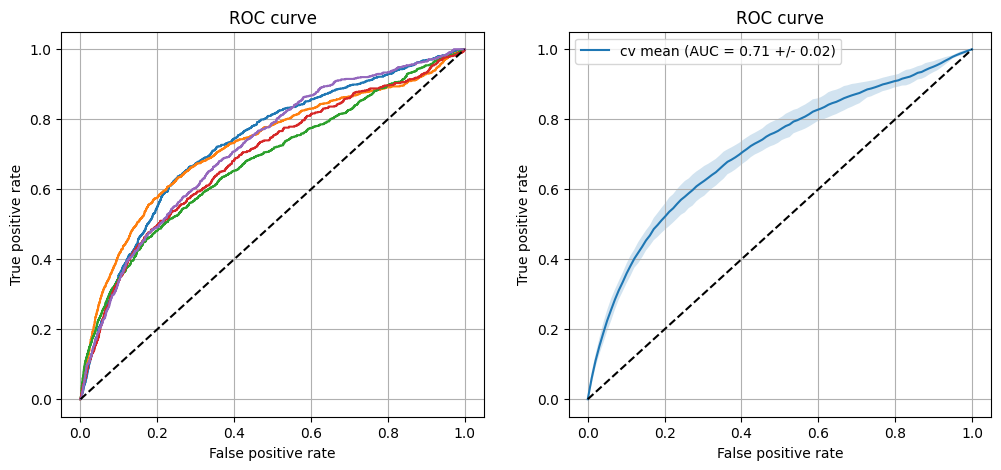

In [16]:
# for each subgoup of data, create a regressor and evaluate it
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

tpr, fpr, auc  = [], [], []

for cv, test in dataframe.groupby('cv_group'):
    # create a regressor

    train = dataframe[dataframe['cv_group'] != cv]
    train = train.dropna(subset=[f'mbp_ema_{HALF_TIME_FILTERING}'])
    test = test.dropna(subset=[f'mbp_ema_{HALF_TIME_FILTERING}'])
    x_train = train[f'mbp_ema_{HALF_TIME_FILTERING}'].values.reshape(-1, 1)
    y_train = train['label'].values
    # evaluate it
    model = RidgeClassifier()
    model.fit(x_train, y_train)

    x_test = test[f'mbp_ema_{HALF_TIME_FILTERING}'].values.reshape(-1, 1)
    y_test = test['label'].values
    y_pred = model.decision_function(x_test)


    fpr_, tpr_, _ = roc_curve(y_test, y_pred)
    tpr.append(tpr_)
    fpr.append(fpr_)

    auc.append(roc_auc_score(y_test, y_pred))

# plot the ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(len(tpr)):
    plt.plot(fpr[i], tpr[i], label=f'cv {i} (AUC = {auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.grid()

plt.subplot(1, 2, 2)
fpr_mean = np.linspace(0, 1, 100)
tpr_mean = np.zeros(100)
tpr_std = np.zeros(100)
for j in range(len(fpr_mean)):
    tpr_mean[j] = np.mean([np.interp(fpr_mean[j], fpr[i], tpr[i]) for i in range(len(tpr))])
    tpr_std[j] = np.std([np.interp(fpr_mean[j], fpr[i], tpr[i]) for i in range(len(tpr))])

plt.fill_between(fpr_mean, tpr_mean - tpr_std, tpr_mean + tpr_std, alpha=0.2)
plt.plot(fpr_mean, tpr_mean, label=f'cv mean (AUC = {np.mean(auc):.2f} +/- {pd.Series(auc).std():.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.grid()
plt.show()
